In [26]:
# First try to use the data to train a model
import numpy as np
import random
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import math
import csv
from sklearn.neural_network import MLPRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np
from sklearn.ensemble import RandomForestRegressor

print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load the dataset from the file
SensorValues = pd.read_csv('mySensorData.csv', header = None)
LocationValues = pd.read_csv('myLocationData.csv', header = None)
# SortedVal = pd.read_csv('mySortedVal.csv', header = None)
# SortedTest = pd.read_csv('mySortedTest.csv', header = None)

SensorValues.head()
LocationValues.head()
# SortedValues.head()

sensor_arr = SensorValues.values
location_arr = LocationValues.values
# sorted_val= SortedVal.values
# sorted_test= SortedTest.values

print(sensor_arr.shape)
print(location_arr.shape)
# print(sorted_val.shape)
# print(sorted_test.shape)

print(np.min(sensor_arr))
print(np.max(sensor_arr))


(2000, 96)
(2000, 3)
-0.0005665736473716
0.0009394403535815


In [5]:
def min_max_scaler(data):
    # Calculate the minimum and maximum values of the data
    
    min_val = np.min(data)
    max_val = np.max(data)
    
    scaled_data = (data - min_val) / (max_val - min_val)
    
    return scaled_data

def zscore_scaler(data):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)
    
    scaled_data = (data - mean) / std
    
    return scaled_data

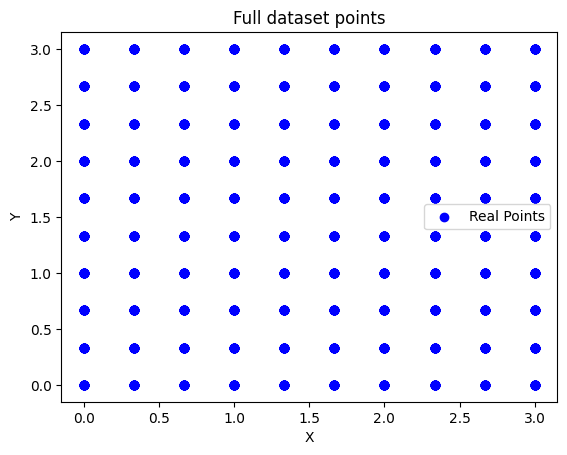

In [6]:
# Preview the Location of the real data points

plt.scatter(location_arr[:,0], location_arr[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Full dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
        


In [7]:
train_size_per = 0.7    # 70% of the data is used for training
                    # 15% of the data is used for validation
                    # 15% of the data is used for testing
rotation_per_position = 4

reads_per_position = 5    

total_values_per_position = rotation_per_position * reads_per_position              


X = min_max_scaler(sensor_arr)
Y = location_arr


data_sen_size = int(X.shape[0])
data_sen_size_2 = int(X.shape[1])

data_loc_size = int(Y.shape[0])
data_loc_size_2 = int(Y.shape[1])

data_size_rotation = int(data_sen_size / total_values_per_position)

val_test_size_per = int(data_size_rotation * (1 - train_size_per))

random_numbers = random.sample(range(0, data_size_rotation), val_test_size_per)

random.shuffle(random_numbers)

halfway = len (random_numbers) // 3

test_random = random_numbers[:halfway]
val_random = random_numbers[halfway:3*halfway]

val_size = int(data_sen_size * (1 - train_size_per)*2/3)
test_size = int(data_sen_size * (1 - train_size_per)*1/3)
train_size = int(data_sen_size * train_size_per)

val_numbers = np.zeros((val_size, 1))
test_numbers = np.zeros((test_size, 1))

n_val = 0
for i in val_random:
    for j in range(0, total_values_per_position):
        val_numbers[n_val] = i * total_values_per_position + j
        n_val = n_val + 1

n_test = 0
for i in test_random:
    for j in range(0, total_values_per_position):
        test_numbers[n_test] = i * total_values_per_position + j
        n_test = n_test + 1
        
val_sorted = np.sort(val_numbers, axis=0)
test_sorted = np.sort(test_numbers, axis=0)


# with open('mySortedVal.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in val_sorted:
#         writer.writerow(row)
     
# with open('mySortedTest.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     for row in test_sorted:
#         writer.writerow(row)   
        
X_train = np.zeros((train_size, data_sen_size_2))
Y_train = np.zeros((train_size, data_loc_size_2))

X_val = np.zeros((val_size, data_sen_size_2))
Y_val = np.zeros((val_size, data_loc_size_2))

X_test = np.zeros((test_size, data_sen_size_2))
Y_test = np.zeros((test_size, data_loc_size_2))

n_test = 0
n_train = 0
n_val = 0

for i in range (0, data_sen_size):
    if i in val_sorted:
        X_val[n_val] = X[i]
        Y_val[n_val] = Y[i]
        n_val = n_val + 1
    elif i in test_sorted:
        X_test[n_test] = X[i]
        Y_test[n_test] = Y[i]
        n_test = n_test + 1
    else:
        X_train[n_train] = X[i]
        Y_train[n_train] = Y[i]
        n_train = n_train + 1


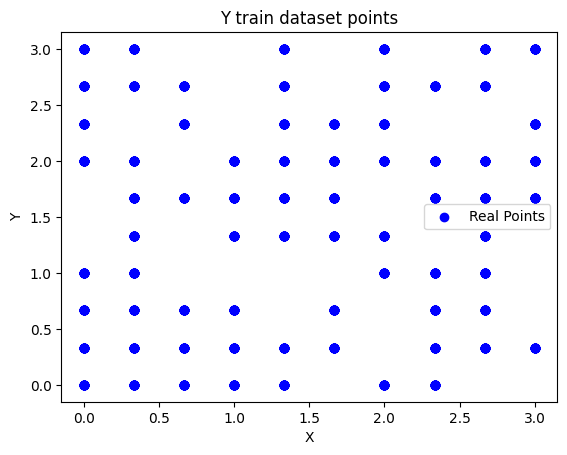

In [8]:
# Split the data into training and testing sets
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y train dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

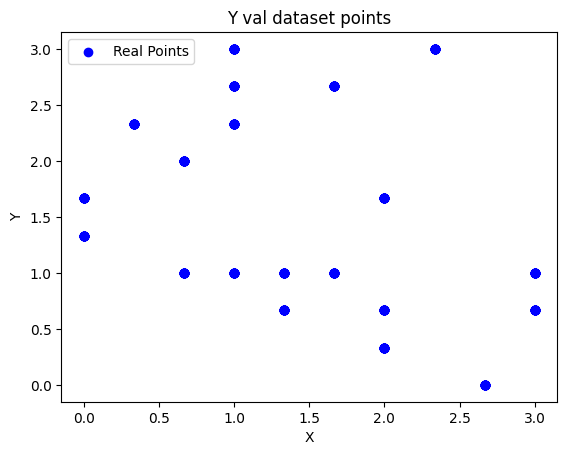

In [9]:
plt.scatter(Y_val[:,0], Y_val[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y val dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

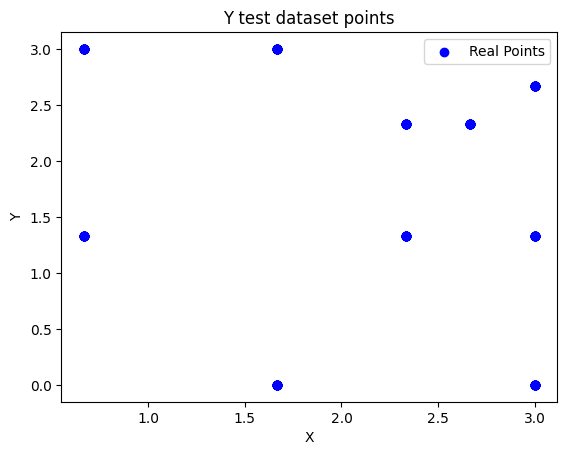

In [10]:
plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y test dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

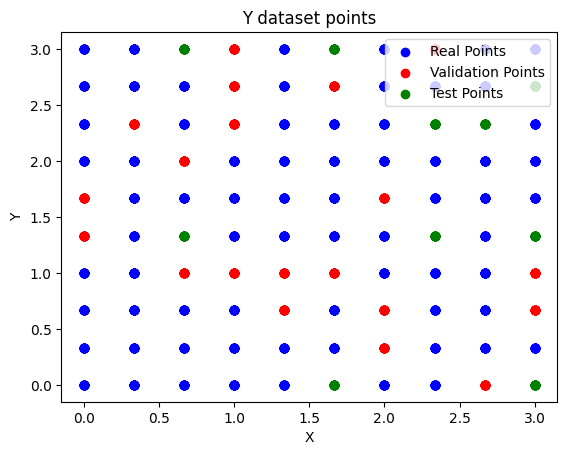

In [11]:
plt.scatter(Y_train[:,0], Y_train[:,1], color='blue', label='Real Points')
plt.scatter(Y_val[:,0], Y_val[:,1], color='red', label='Validation Points')
plt.scatter(Y_test[:,0], Y_test[:,1], color='green', label='Test Points')

# # Set the x-axis label to "X"
plt.xlabel('X')

# # Set the y-axis label to "Y"
plt.ylabel('Y')

# # Set the title of the plot to "Real vs Predicted Points"
plt.title('Y dataset points')

# # Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [12]:
# Machine Learning - Loss Functions for X and Y

def loss_function_xy(y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = (K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [13]:
# Machine Learning - Metric Functions for X and Y

def xy_metric (y_true, y_pred):
    xy_true = y_true[:, :2]
    xy_pred = y_pred[:, :2]
    y_true = xy_true[:, 1]
    x_true = xy_true[:, 0]
    y_pred = xy_pred[:, 1]
    x_pred = xy_pred[:, 0]
    distance = tf.reduce_mean(K.sqrt(K.square(y_pred - y_true) + K.square(x_pred - x_true)))
    return distance

In [14]:
# Machine Learning - Loss Functions for theta

def loss_function_theta(y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [15]:
# Machine Learning - Metric Functions for theta

def theta_metric (y_true, y_pred):
    theta_true = y_true
    theta_pred = y_pred
    return tf.reduce_mean(tf.abs(theta_true - theta_pred))

In [30]:

# Machine Learning - Scikit-optimizer

search_space = [Real(0.0001, 0.1, name='learning_rate'),
                Integer(1,1000, name = 'n_estimators'),
                Integer(1,1000, name = 'max_depth')]

@use_named_args(search_space)
def objective(learning_rate, n_estimators, max_depth):
    model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth)
    model.fit(X_train, Y_train)

    y_pred = model.predict(X_val)
    
    mse = loss_function_xy(Y_val, y_pred)

    return mse

result = gp_minimize(objective, search_space, n_calls=100, random_state=42)

print("Best score=%.4f" % result.fun)
print("Best parameters:", result.x)
    




ValueError: `func` should return a scalar

In [246]:
# Machine Learning - Build the model

inputs = tf.keras.Input(shape=(data_sen_size_2,))

x = tf.keras.layers.Dense(96, activation='relu')(inputs)
x = tf.keras.layers.Dense(48, activation='relu')(x)
x = tf.keras.layers.Dense(24, activation='relu')(x)
x = tf.keras.layers.Dense(12, activation='relu')(x)

xy_output = tf.keras.layers.Dense(2, activation='linear', name='xy')(x)
theta_output = tf.keras.layers.Dense(1, activation='linear', name='theta')(x)

model = tf.keras.Model(inputs=inputs, outputs=[xy_output, theta_output])

model.summary()

optimizer = Adam(learning_rate=0.0001)
# model.compile(loss = 'SparseCategori', optimizer = 'adam', metrics = ['accuracy'])
model.compile(optimizer = optimizer, loss = {'xy': loss_function_xy, 'theta': loss_function_theta}, loss_weights={'xy': 0.99, 'theta': 0.01}, metrics = {'xy': xy_metric, 'theta': theta_metric})

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 dense_103 (Dense)              (None, 96)           9312        ['input_20[0][0]']               
                                                                                                  
 dense_104 (Dense)              (None, 48)           4656        ['dense_103[0][0]']              
                                                                                                  
 dense_105 (Dense)              (None, 24)           1176        ['dense_104[0][0]']              
                                                                                           

In [247]:
# Machine Learning - Train the model
model.fit(X_train, {"xy": Y_train[:, :2], "theta": Y_train[:, 2]}, validation_data=(X_val, {"xy": Y_val[:, :2], "theta": Y_val[:, 2]}), epochs=10000, batch_size=80, verbose = 2)

Epoch 1/10000
18/18 - 1s - loss: 1.9524 - xy_loss: 1.9501 - theta_loss: 2.1818 - xy_xy_metric: 1.9473 - theta_theta_metric: 2.1786 - val_loss: 1.8879 - val_xy_loss: 1.8850 - val_theta_loss: 2.1753 - val_xy_xy_metric: 1.8850 - val_theta_theta_metric: 2.1753 - 629ms/epoch - 35ms/step
Epoch 2/10000
18/18 - 0s - loss: 1.9122 - xy_loss: 1.9097 - theta_loss: 2.1616 - xy_xy_metric: 1.9080 - theta_theta_metric: 2.1584 - val_loss: 1.8430 - val_xy_loss: 1.8398 - val_theta_loss: 2.1562 - val_xy_xy_metric: 1.8398 - val_theta_theta_metric: 2.1562 - 64ms/epoch - 4ms/step
Epoch 3/10000
18/18 - 0s - loss: 1.8733 - xy_loss: 1.8705 - theta_loss: 2.1430 - xy_xy_metric: 1.8672 - theta_theta_metric: 2.1475 - val_loss: 1.7993 - val_xy_loss: 1.7959 - val_theta_loss: 2.1384 - val_xy_xy_metric: 1.7959 - val_theta_theta_metric: 2.1384 - 61ms/epoch - 3ms/step
Epoch 4/10000
18/18 - 0s - loss: 1.8357 - xy_loss: 1.8328 - theta_loss: 2.1253 - xy_xy_metric: 1.8312 - theta_theta_metric: 2.1223 - val_loss: 1.7574 - val

In [248]:
# Machine Learning - Evaluate the model

losses = model.evaluate(X_test, {'xy': Y_test[:, :2], 'theta': Y_test[:, 2]}, batch_size=32)
print("Mean Squared Error: ", losses)


7/7 [==============================] - 0s 2ms/step - loss: 0.2995 - xy_loss: 0.2874 - theta_loss: 1.4930 - xy_xy_metric: 0.2870 - theta_theta_metric: 1.5717
Mean Squared Error:  [0.2994571924209595, 0.2874011695384979, 1.4930014610290527, 0.2870253920555115, 1.5717122554779053]


7/7 [==============================] - 0s 2ms/step
Mean Error for test data (distance):  0.3632415786283892 meters
Mean squared error for test data (degrees):  1.7370436614603806 degrees
#############################################################################################################
Mean Error for test data (distance):  tf.Tensor(0.4302695929307864, shape=(), dtype=float64) meters


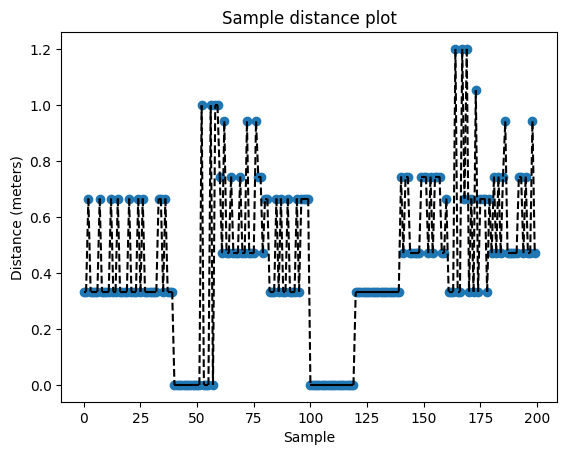

In [249]:
# Machine Learning - Make predictions

y_pred, theta_pred = model.predict(X_test)

y_pred_x = y_pred[:, 0]
y_pred_y = y_pred[:, 1]
y_pred_theta = theta_pred

# Round the predicted values to the nearest integer
y_pred_x = np.rint(y_pred_x.flatten())
y_pred_y = np.rint(y_pred_y.flatten())
y_pred_theta = np.rint(y_pred_theta.flatten())

# Combine the predicted x and y values into a single array of (x, y) tuples
y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

# Calculate accuracy score
mse = metrics.mean_squared_error(Y_test[:, :2], y_pred)

print("Mean Error for test data (distance): ", math.sqrt(mse), "meters" )

mse = metrics.mean_squared_error(Y_test[:, 2], y_pred_theta)
print("Mean squared error for test data (degrees): ", math.sqrt(mse), "degrees" )

print("#############################################################################################################")

err = tf.reduce_mean(tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))
print("Mean Error for test data (distance): ", err, "meters")


distance = (tf.sqrt(tf.square(Y_test[:, 0] - y_pred[:, 0]) + tf.square(Y_test[:, 1] - y_pred[:, 1])))

fig, ax = plt.subplots()

ax.scatter(range(len(distance)), distance)

ax.set_xlabel('Sample')
ax.set_ylabel('Distance (meters)')
ax.set_title('Sample distance plot')


# Show lines between adjacent samples
for i in range(len(distance)-1):
    ax.plot([i, i+1], [distance[i], distance[i+1]], 'k--')

# Show the plot
plt.show()

7/7 [==============================] - 0s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


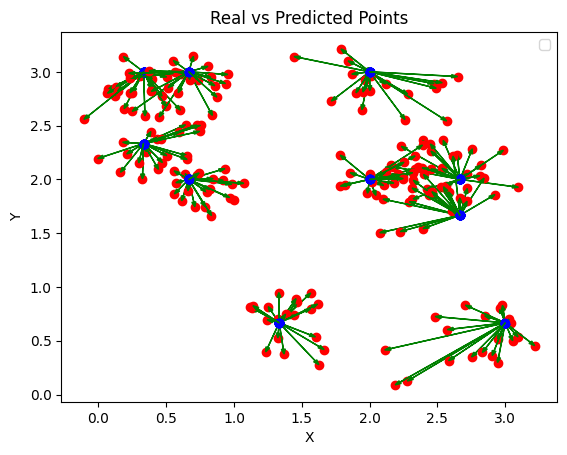

In [250]:

# Assume you have a trained model called "model"
# and a test set called X_test and y_test

# Make predictions on the test set
y_pred, theta_pred = model.predict(X_test)

# Create a scatter plot showing the real points in blue
# plt.scatter(Y_test[:,0], Y_test[:,1], color='blue', label='Real Points')

x_pred = y_pred[:, 0]
y_pred = y_pred[:, 1]

# Create a scatter plot showing the predicted points in red
# plt.scatter(x_pred, y_pred, color='red', label='Predicted Points')

# Loop through each point in the test set
for i in range(0 , 200):
    # Get the x and y coordinates for the real and predicted points
    x_real, y_real, theta_real = Y_test[i]
    x_pred_arrow = x_pred[i]
    y_pred_arrow = y_pred[i]
    plt.scatter(x_real, y_real, color='blue')
    plt.scatter(x_pred_arrow, y_pred_arrow, color='red')
    # Add an arrow from the real point to the predicted point
    plt.arrow(x_real, y_real, x_pred_arrow - x_real, y_pred_arrow - y_real, 
              length_includes_head=True, head_width=0.03, color='green')
    
# Set the x-axis label to "X"
plt.xlabel('X')

# Set the y-axis label to "Y"
plt.ylabel('Y')

# Set the title of the plot to "Real vs Predicted Points"
plt.title('Real vs Predicted Points')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()